In [54]:
import librosa.display
import librosa

from scipy import signal
from scipy.io import wavfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from math import log

from scipy import interpolate

# 1. Generating Spectogram

In [55]:
def read_signal(audioData):
    samplerate, data = wavfile.read(audioData)
    print('Data size: ', data.shape[0])
    print('Sample rate of signal:',samplerate)
    return samplerate , data

def plot_signal(samplerate , data):
    duration = data.shape[0]/samplerate
    time = np.arange(0,duration,1/samplerate) #time vector form
    plt.figure(figsize=(25,10))
    plt.plot(time,data)
    plt.xlabel('Time [sec]')
    plt.ylabel('Amplitude')
    plt.title('Audio Data')
    plt.show()

In [56]:
#stft
def generate_spectogram(f, t, Zxx):
    plt.figure(figsize=(25, 10))
    plt.pcolormesh(t,f,np.abs(Zxx), shading = 'gouraud')
    plt.xlabel('Time [sec]')
    plt.ylabel('Frequency [Hz]')
    plt.title('Spectogram')
    plt.show()
#ISTFT
def inverse_spectogram(transformedZ ,samplerate,nperseg=4096,window = 'hamming', noverlap=3*1024//4):
    _, xrec = signal.istft(transformedZ, samplerate)
    plt.figure(figsize=(25,10))
    plt.plot(_, xrec)

In [57]:
%%time
samplerate , data = read_signal('audio.wav')

Data size:  66150
Sample rate of signal: 22050
Wall time: 1e+03 µs


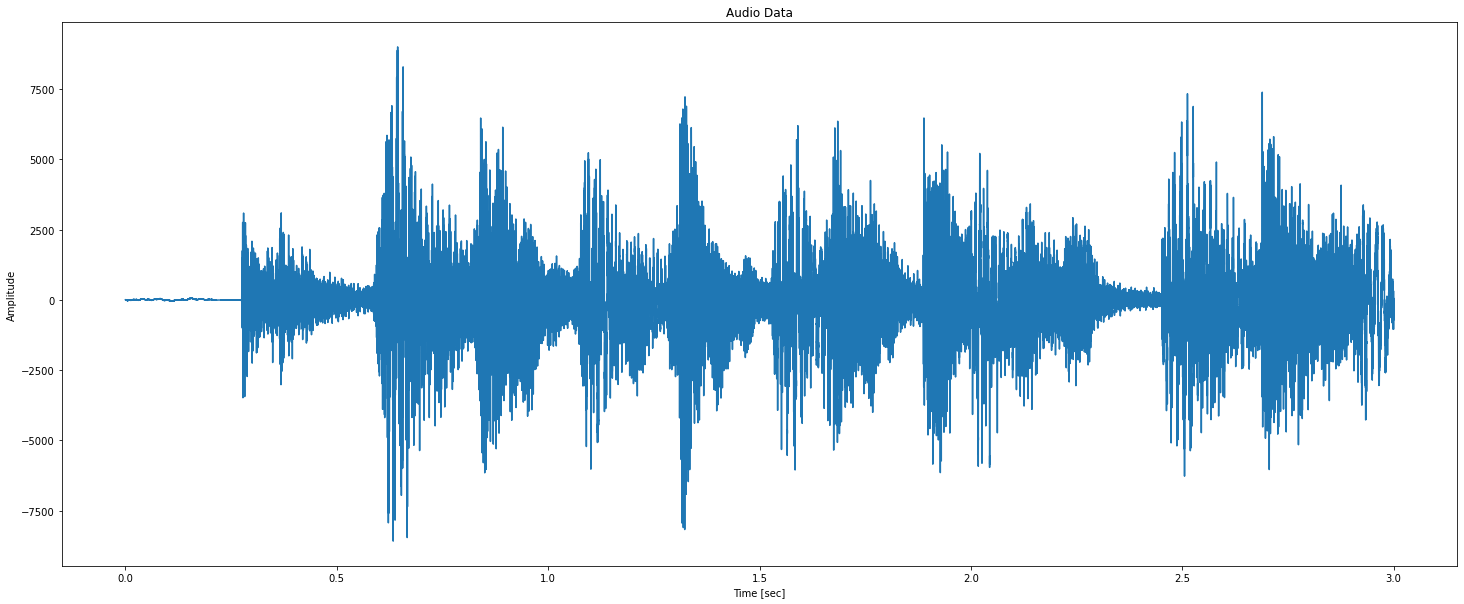

In [58]:
plot_signal(samplerate,data)

In [59]:
f, t, Zxx = signal.stft(x=data,fs=samplerate,window = 'hamming', nperseg = 8192, noverlap = 3*8192//4)

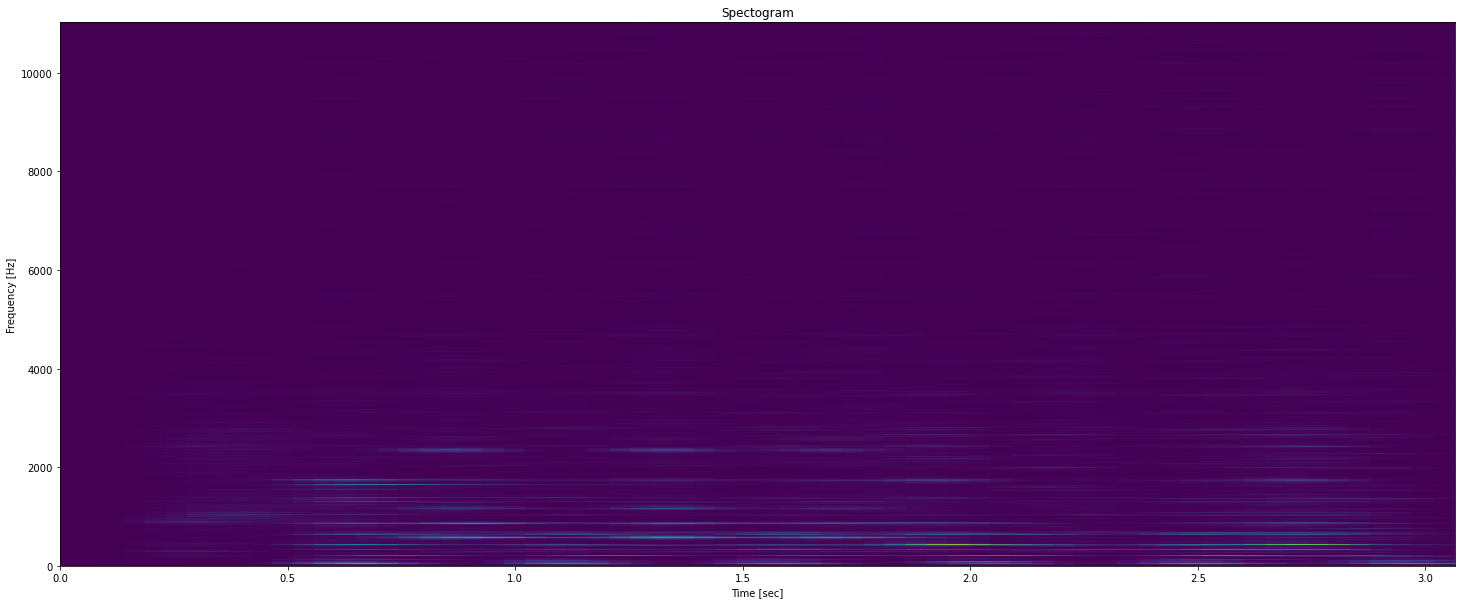

Wall time: 1.62 s


In [60]:
%%time
generate_spectogram(f, t, Zxx)

Wall time: 24 ms


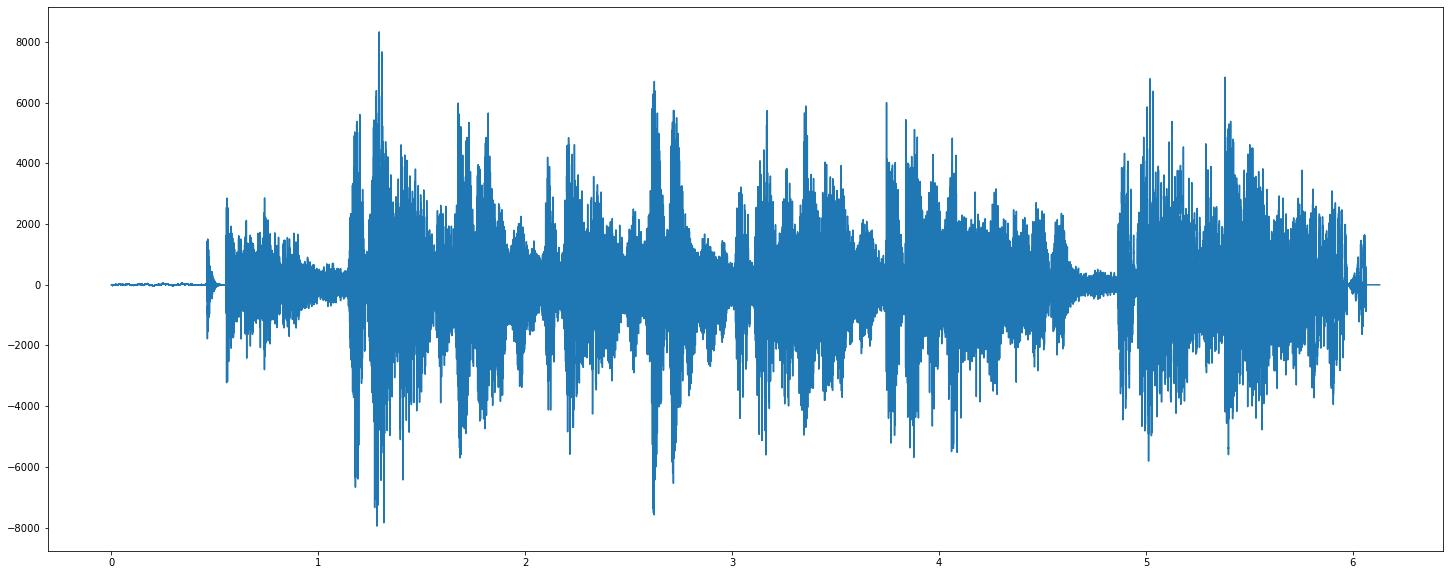

In [61]:
%%time
inverse_spectogram(Zxx,samplerate)

note: fix the scale in the returned signal data

# 2. SPline Interpolation

In [62]:
def spinterpolate(x , y, xp):
    f = interpolate.interp1d(x, y)
    yp = f(xp)
    return yp

In [63]:
points_x = [0,1,2,3,4,5,6,7,8,9]
points_y = [0.053, 1.477, 1.970, 3.279, 4.153,4.934, 5.178, 5.828, 6.082, 6.484]
spinterpolate(points_x,points_y, points_x)

array([0.053, 1.477, 1.97 , 3.279, 4.153, 4.934, 5.178, 5.828, 6.082,
       6.484])

# 3. dB to linear Scale Conversion

In [64]:
def safe_log10(x, eps=1e-12):
    return np.log10(x+eps)
    

def convert_to_dB(raw_value):
    # from math import log
    return 20*safe_log10(raw_value)

In [65]:
print(convert_to_dB(10000000))

140.0


# 4. Signal Equalizer

In [66]:
HeadphonesName = input('Select Your Headphones Name:')

Select Your Headphones Name:Anker SoundCore Space NC Wireless


In [67]:
sD = pd.read_csv(f'HeadphonesData/{HeadphonesName}.csv')

In [68]:
sD.drop(['Unnamed: 0'], axis =1 , inplace = True)
sD

,Frequency,Left,Right,Target Response
0,9.857,106.315,101.603,90
1,10.000,106.429,101.759,90
2,10.145,106.379,101.763,90
3,10.293,106.356,101.805,90
4,10.443,106.350,101.870,90
...,...,...,...,...
529,20480.000,73.005,72.136,90
530,20777.888,72.949,72.490,90
531,21080.110,72.521,71.796,90
532,21386.727,71.444,70.210,90


In [69]:
left = sD['Left'].tolist()
right = sD['Right'].tolist()
freq = sD['Frequency'].tolist()
targ = sD['Target Response'].tolist()
invleft = (1/sD['Left']).tolist()

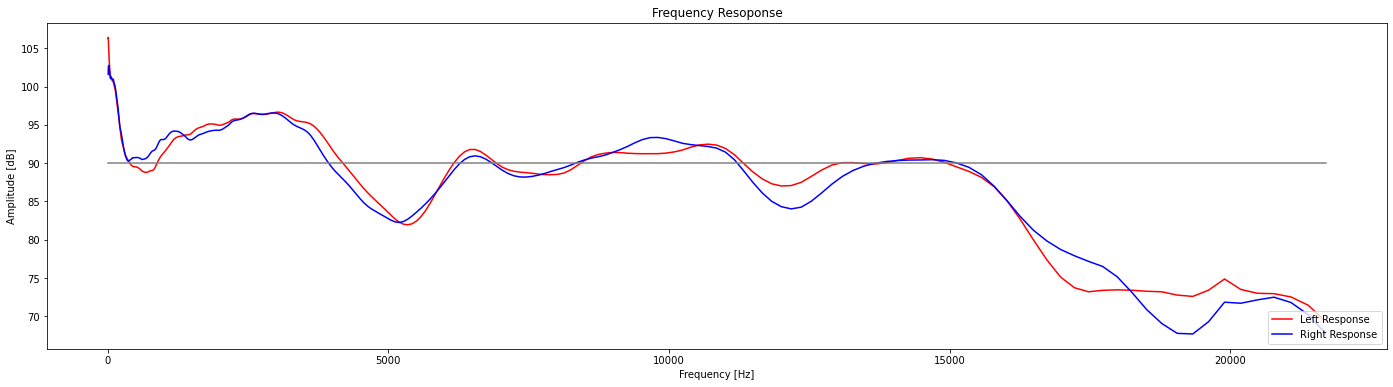

In [70]:
plt.figure(figsize=(24,6))
plt.title('Frequency Resoponse')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.plot(freq,left, color = "red")
plt.plot(freq,right, color = 'blue')
plt.plot(freq, targ, color = 'grey')
plt.legend(["Left Response", "Right Response"], loc ="lower right")

In [71]:
eqleft = (1/sD['Left']).tolist()
eqright = (1/sD['Right']).tolist()

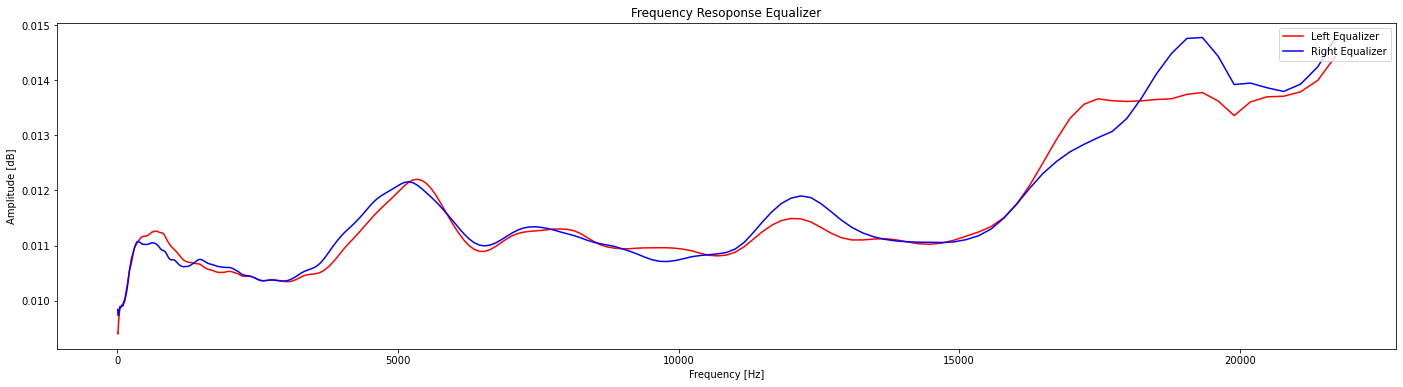

In [72]:
plt.figure(figsize=(24,6))
plt.title('Frequency Resoponse Equalizer')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.plot(freq, eqleft, color = 'red')
plt.plot(freq, eqright, color = 'blue')
plt.legend(["Left Equalizer", "Right Equalizer"], loc ="upper right")

In [73]:
#Value of G(f)
GfLeft = []
GfRight = []
nums = []
for i in range(len(f)): 
    if f[i]> freq[0]:
        GfLeft.append(spinterpolate(freq , eqleft , f[i]))
        GfRight.append(spinterpolate(freq, eqright, f[i]))
    else:
        nums.append(i)

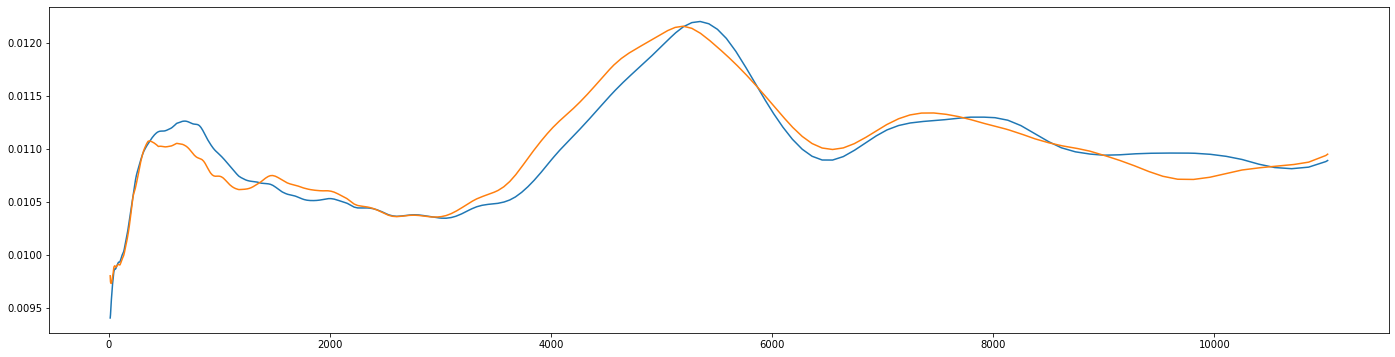

In [74]:
plt.figure(figsize = (24,6))
plt.plot(f[nums[-1]+1:len(f)] , GfLeft)
plt.plot(f[nums[-1]+1:len(f)] , GfRight)

In [75]:
X_w_k = Zxx[nums[-1]+1:len(Zxx)]

In [76]:
yfLeft = []
yfRight = []

In [77]:
for i in range(len(X_w_k)):
    yfLeft.append(GfLeft[i]*Zxx[i])
    yfRight.append(GfRight[i]*Zxx[i])

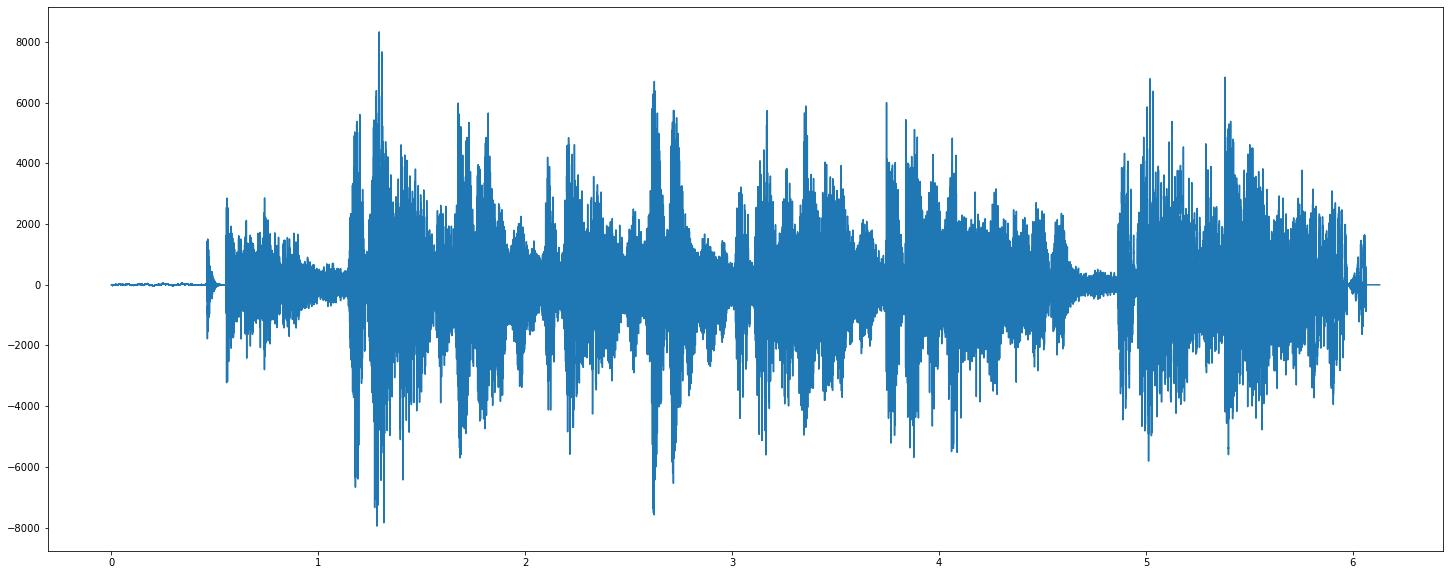

In [78]:
transform(yfLeft,samplerate, 'inverse')

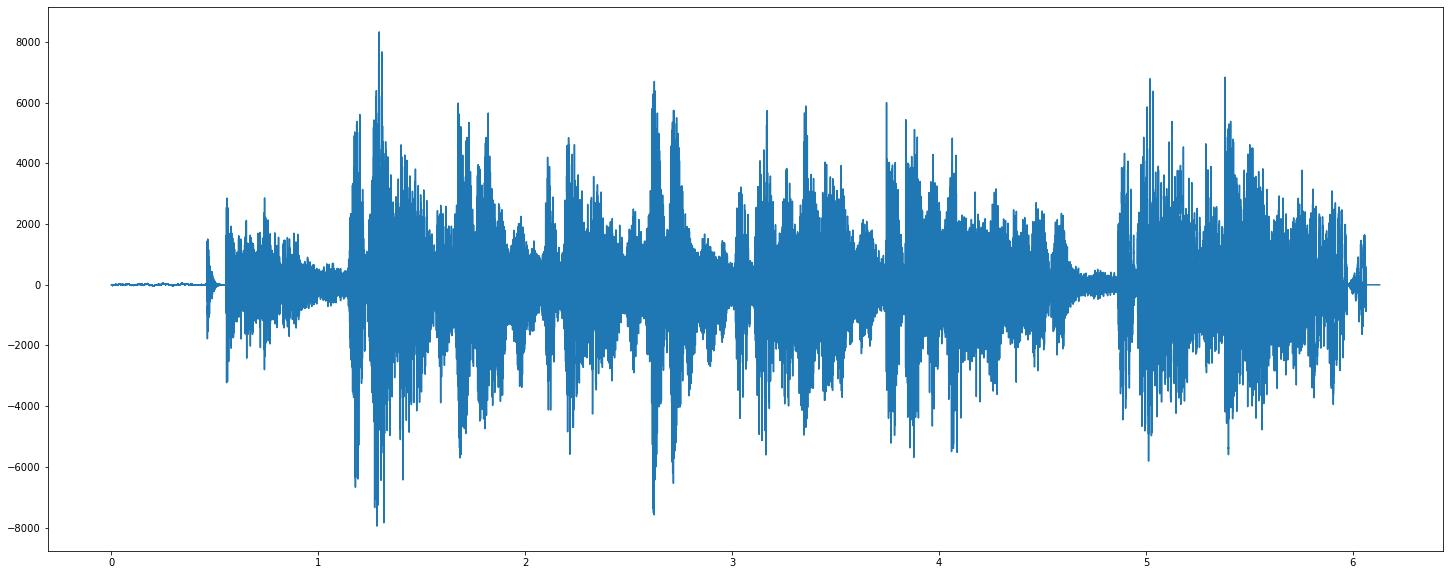

In [79]:
transform(yfRight,samplerate, 'inverse')